In [1]:
import os
import requests
import pandas as pd
import numpy as np
import healpy as hp
import subprocess as sp
import ligo.skymap.plot
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.time import Time
from scipy.optimize import curve_fit
from ligo.skymap.io import read_sky_map
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
u_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers.csv"))
u_triggers_with_prob = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers_with_probs.csv"))
all_grbs = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_grbs.csv"))
all_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_triggers.csv"))
print("Total number of triggers: ", len(u_triggers))
u_triggers_with_link = len(u_triggers[u_triggers['url']!='None'])
print("Total number of triggers with link to some data products: ", u_triggers_with_link)
print("Total number of triggers that have some sort of probability map: ", len(u_triggers_with_prob))
print("Total number of triggers that have healpix map: ", len(u_triggers_with_prob[u_triggers_with_prob['healpix']==0]))
print("Total number of triggers that have locprob (old) map: ", len(u_triggers_with_prob[u_triggers_with_prob['locprob']==0]))
print("Total number of triggers that have both maps: ", len(u_triggers_with_prob[(u_triggers_with_prob['healpix']==0) & (u_triggers_with_prob['locprob']==0)]))
print("Total number of GRBs confirmed by Fermi: ", len(all_grbs))
real_grbs = all_grbs['trigger_name'].values
triggers_with_prob = u_triggers_with_prob['GRBName'].values
grb_with_prob = np.intersect1d(real_grbs, triggers_with_prob)
real_grb_triggers = []
for real_grb in real_grbs:
    real_grb_triggers.append(np.unique(u_triggers[u_triggers['url'].str.contains(real_grb)]['trigger_no'].values))
real_grb_triggers = np.concatenate(real_grb_triggers)
real_grb_triggers_with_prob = np.intersect1d(real_grb_triggers, u_triggers_with_prob['Trig_no'].values)
grb_with_link = np.intersect1d(real_grb_triggers, u_triggers['trigger_no'].values)
print("Total number of real GRBs with link to some data products: ", len(grb_with_link))
print("Total number of real GRBs that have corresponding probability maps: ", len(grb_with_prob))
print(np.setdiff1d(real_grbs, triggers_with_prob),"\nThe above GRBs do not have probability maps")
long_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Long GRB")]['TrigNum'].values)
actual_long_grb = np.intersect1d(long_grbs, real_grb_triggers)
actual_long_grb_with_prob = np.intersect1d(long_grbs, real_grb_triggers_with_prob)
short_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Short GRB")]['TrigNum'].values)
actual_short_grb = np.intersect1d(short_grbs, real_grb_triggers)
actual_short_grb_with_prob = np.intersect1d(short_grbs, real_grb_triggers_with_prob)
print("Total number of triggers reported as likely Long GRBs: ", len(long_grbs))
print("Out of the these, the number of real GRBs that were reported as likely Long GRBs: ", len(actual_long_grb))
print("Out of the these, the number of real GRBs that were reported as likely Long GRBs and have probability maps: ", len(actual_long_grb_with_prob))
print("Total number of triggers reported as likely Short GRBs: ", len(short_grbs))
print("Out of the these, the number of real GRBs that were reported as likely Short GRBs: ", len(actual_short_grb))
print("Out of the these, the number of real GRBs that were reported as likely Short GRBs and have probability maps: ", len(actual_short_grb_with_prob))

Total number of triggers:  3766
Total number of triggers with link to some data products:  3760
Total number of triggers that have some sort of probability map:  1761
Total number of triggers that have healpix map:  1409
Total number of triggers that have locprob (old) map:  1652
Total number of triggers that have both maps:  1301
Total number of GRBs confirmed by Fermi:  1603
Total number of real GRBs with link to some data products:  1546
Total number of real GRBs that have corresponding probability maps:  1499
['bn170307851' 'bn170430204' 'bn170614505' 'bn170626401' 'bn170726794'
 'bn170926782' 'bn171010875' 'bn171120556' 'bn171212948' 'bn171222684'
 'bn180204109' 'bn180205184' 'bn180618030' 'bn180620660' 'bn180706351'
 'bn180917477' 'bn181016718' 'bn181125371' 'bn181126413' 'bn181225489'
 'bn190109497' 'bn190123513' 'bn190311600' 'bn190323548' 'bn190427190'
 'bn190531568' 'bn190716019' 'bn190821716' 'bn191119261' 'bn191130507'
 'bn200224416' 'bn200416295' 'bn200630076' 'bn200829582

In [3]:
def powerlaw(x, a, b):
    return a * np.power(x, b)

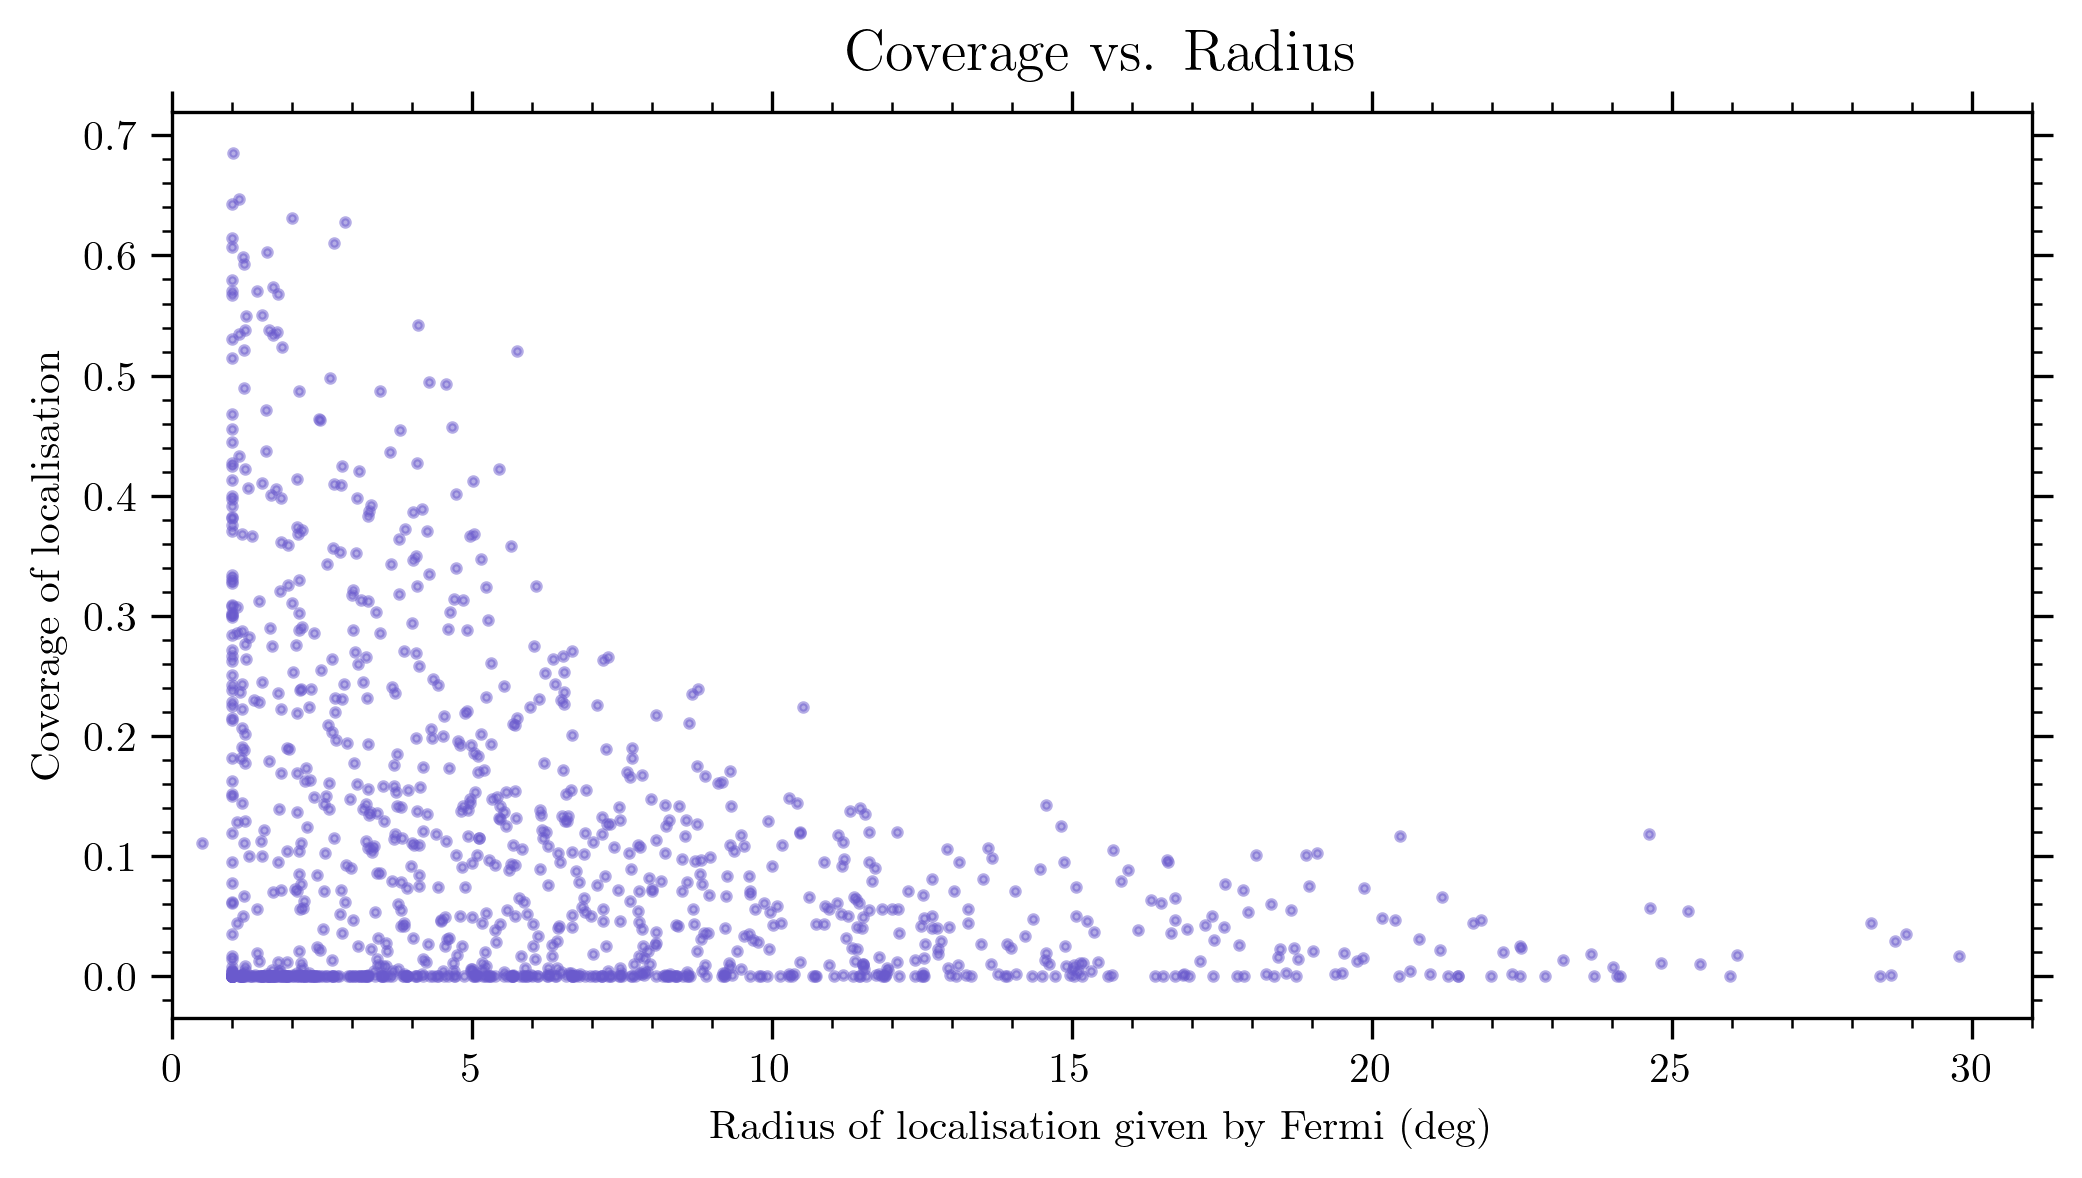

In [4]:
coverage = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/coverage.csv"))
radius = coverage['radius'].values
probs = coverage['coverage'].values
radius = radius[np.where(np.logical_and(probs!='NOT VISIBLE',probs!='None'))].astype(float)
probs = probs[np.where(np.logical_and(probs!='NOT VISIBLE',probs!='None'))].astype(float)
probs = probs[radius<30]
radius = radius[radius<30]
probs = probs[np.argsort(radius)]
radius = radius[np.argsort(radius)]
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(radius, probs, s=4, color='slateblue', alpha=0.5)
plt.xlabel("Radius of localisation given by Fermi (deg)")
plt.ylabel("Coverage of localisation")
plt.title("Coverage vs. Radius", fontsize=14, pad=10)
plt.xlim(0,31)
plt.show()

(0.0, 31.0)

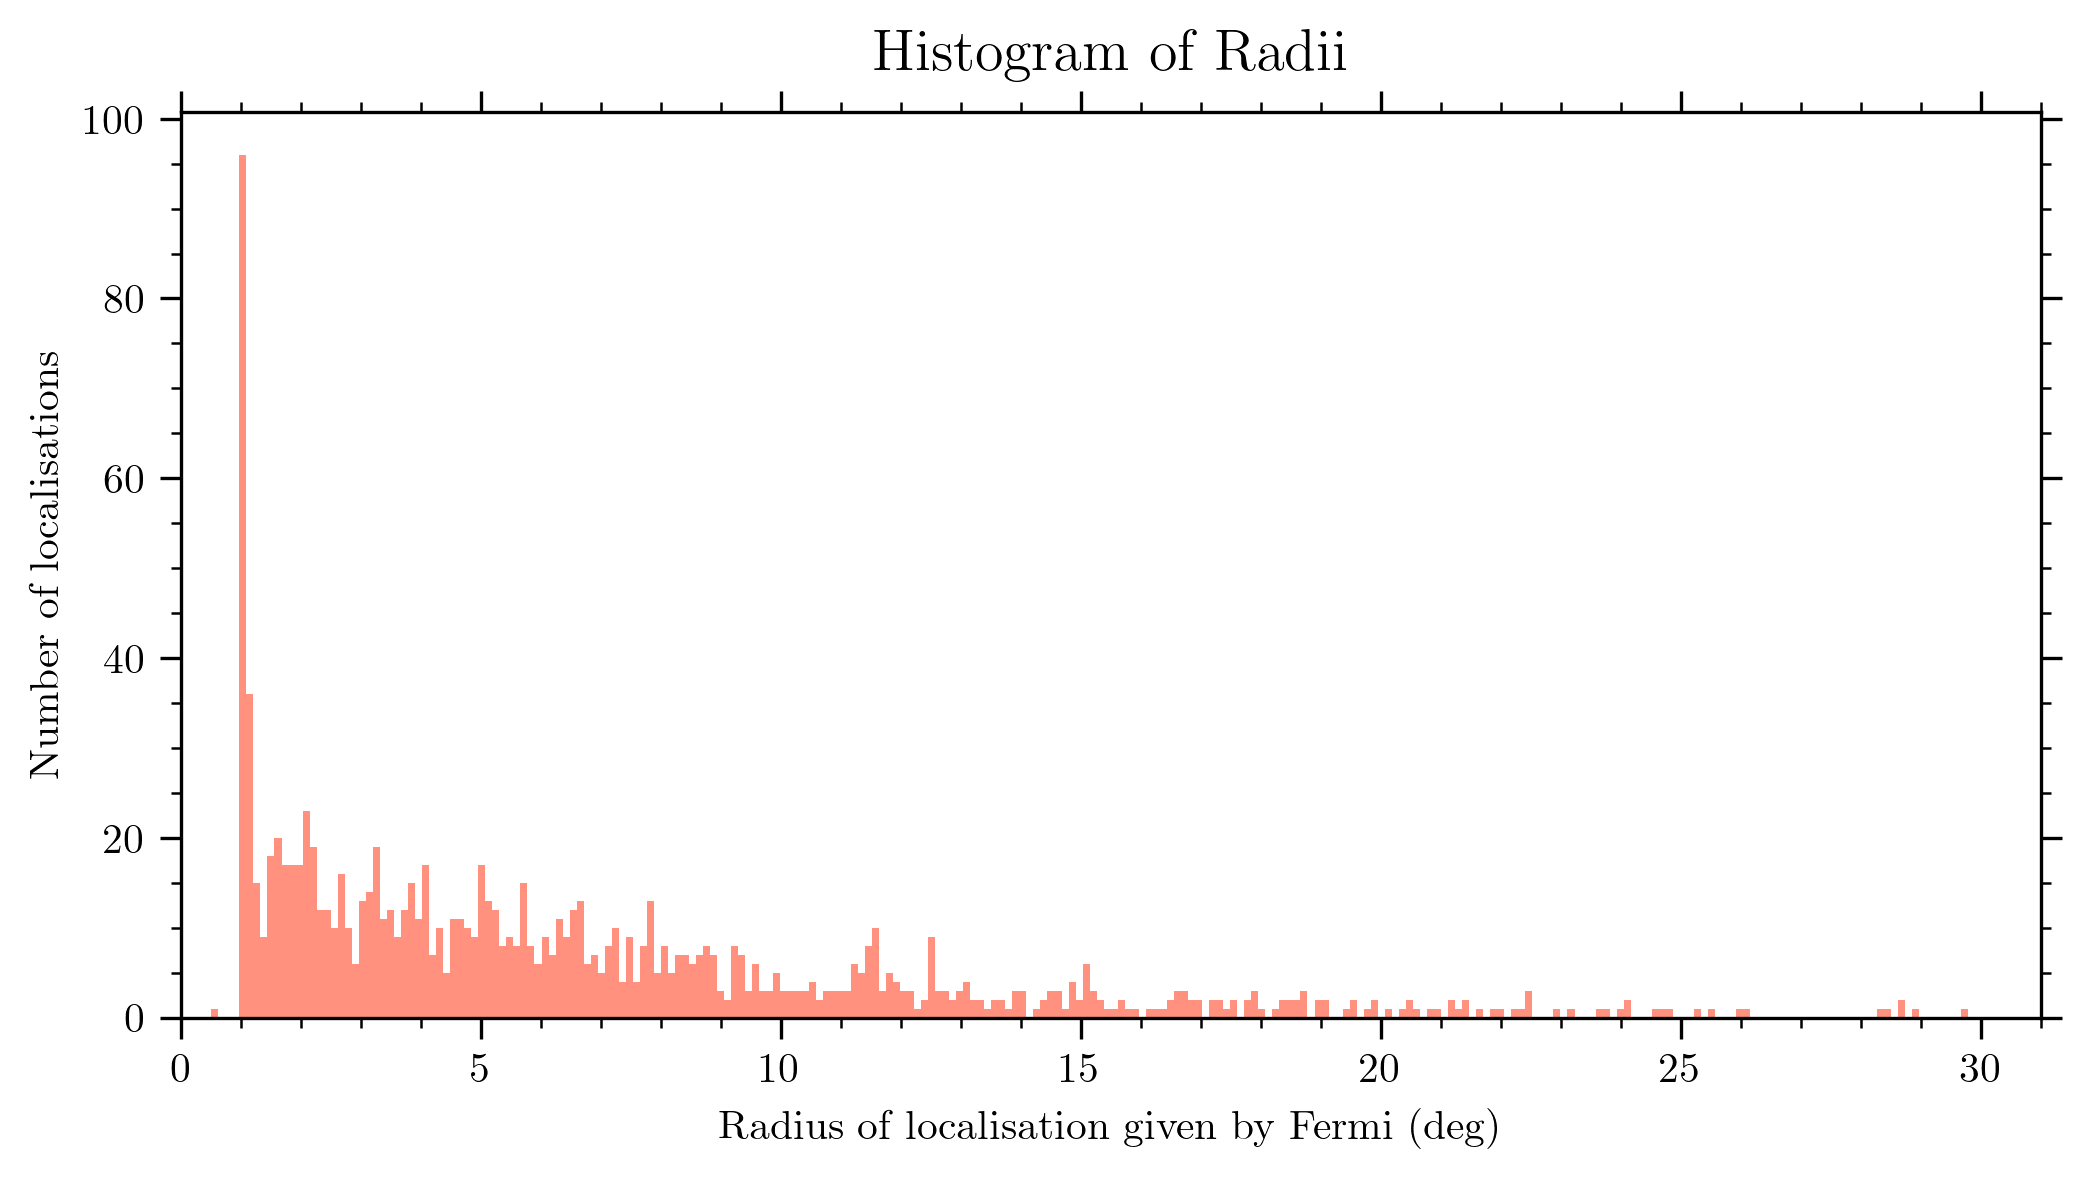

In [5]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(radius, bins=250, color='tomato', alpha=0.7)
plt.xlabel("Radius of localisation given by Fermi (deg)")
plt.ylabel("Number of localisations")
plt.title("Histogram of Radii", fontsize=14, pad=10)
plt.xlim(0,31)

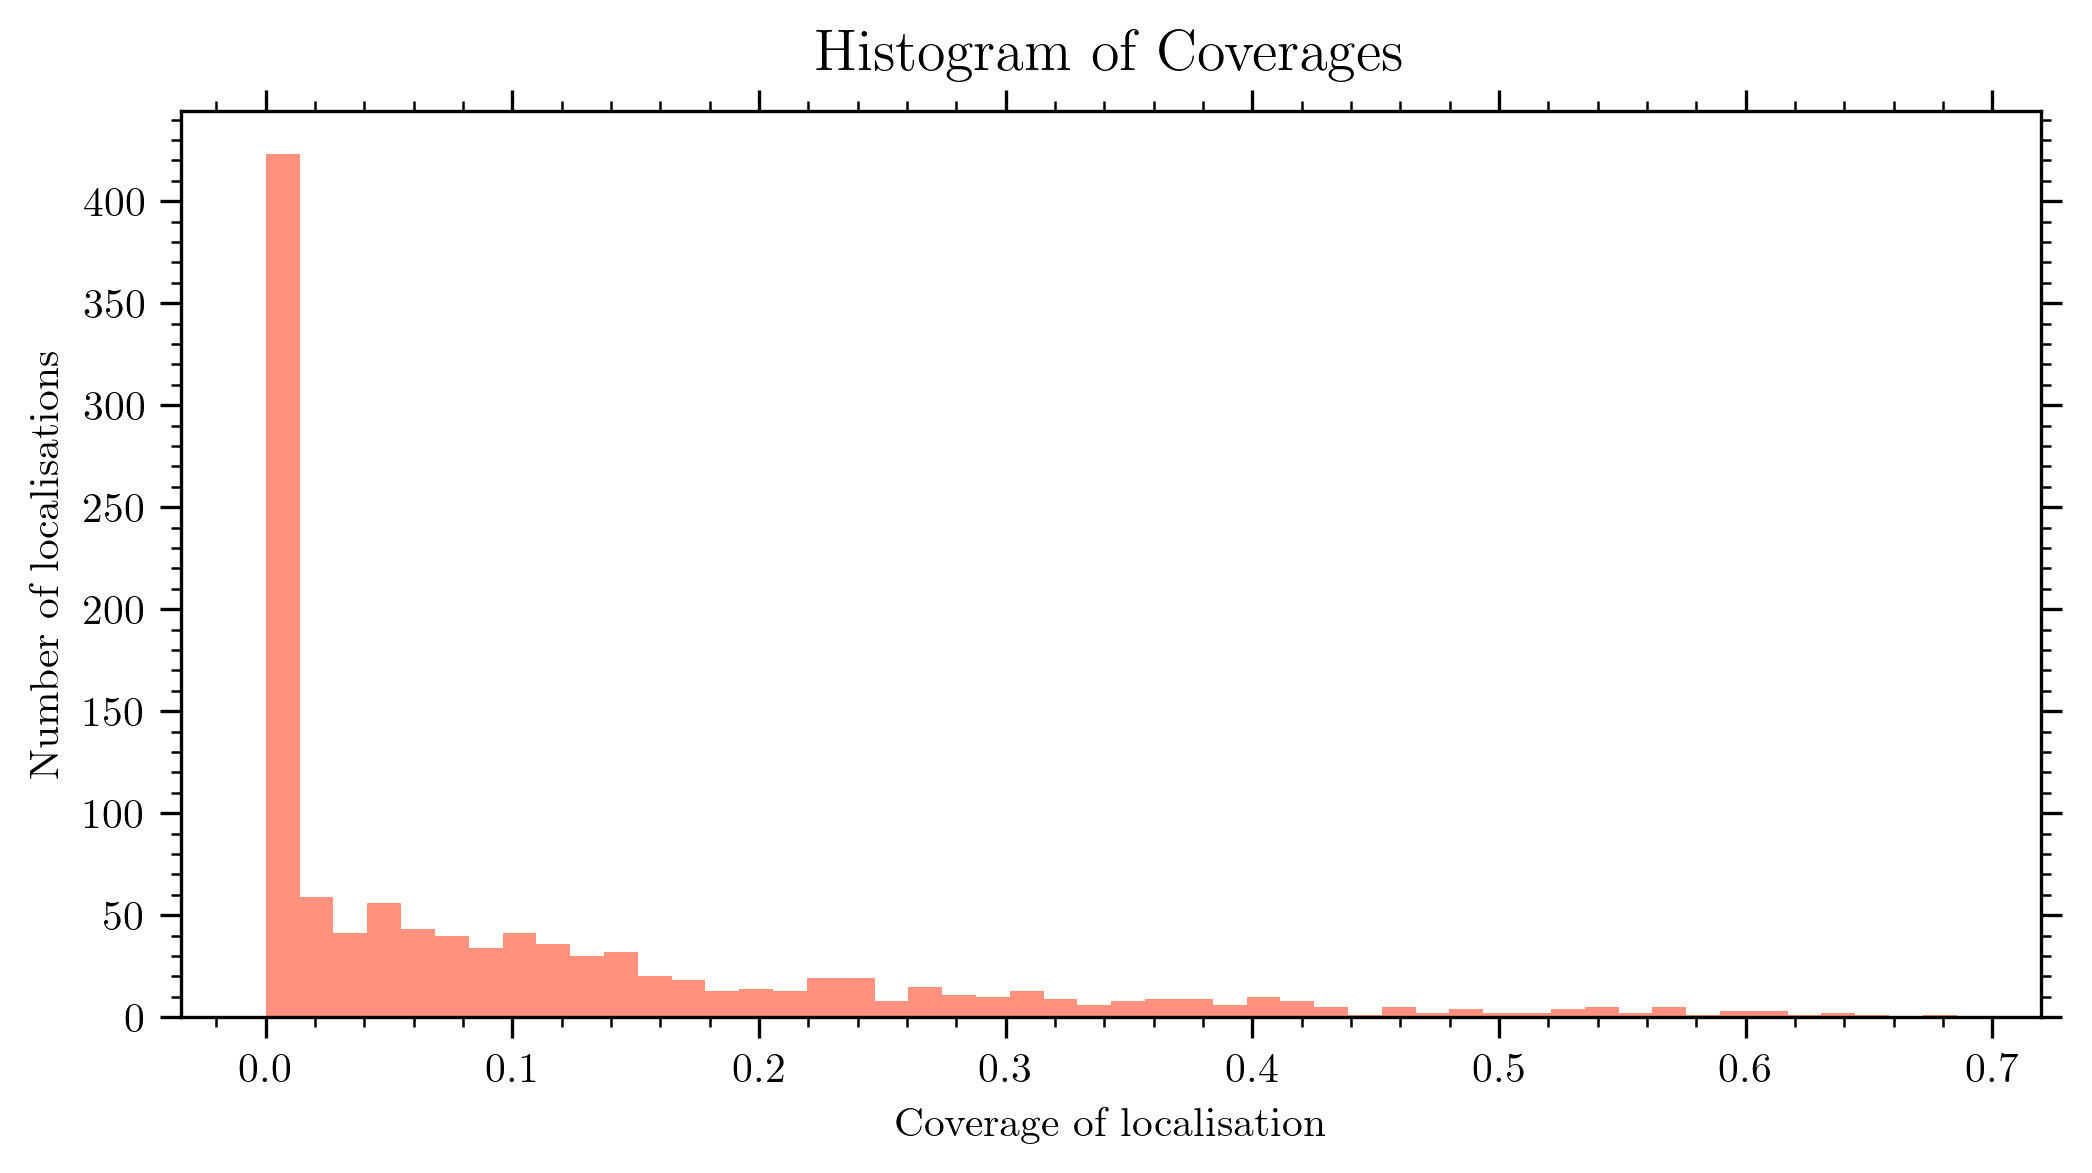

In [6]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(probs, bins=50, color='tomato', alpha=0.7)
plt.xlabel("Coverage of localisation")
plt.ylabel("Number of localisations")
plt.title("Histogram of Coverages", fontsize=14, pad=10)

plt.show()

In [7]:
def get_time_radius(url):
    r = requests.get(url).text
    find_date = r.rfind("NOTICE_DATE:", 0, r.find("LOC_URL:"))
    find_radius = r.rfind("GRB_ERROR:", 0, r.find("LOC_URL:"))
    date = r[find_date+17:find_date+17+22]
    radius = r[find_radius+17:find_radius+17+5]
    return date, radius

In [8]:
get_time_radius("https://gcn.gsfc.nasa.gov/other/679932336.fermi")

('Tue 19 Jul 22 14:15:00', '1.01 ')

0.9999999997541074


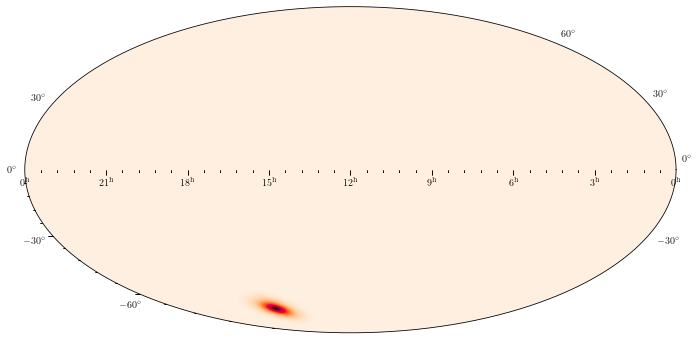

In [9]:
skymap = read_sky_map("/home/ravioli/astro/git/fermi_grbs/data/glg_healpix_all_bn220719587.fit")
hpmap = skymap[0]
print(sum(hpmap))
fig, axes = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': 'astro hours mollweide'})
axes.imshow_hpx(hpmap, cmap='cylon')